In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

## Defining inputs

Need to define some heterogenous factors of production...

In [96]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': 0.0, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [1e-2, 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 0.0, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [1e-1, 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

## Defining a production process

Next need to define some production process...

In [97]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [98]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0}

## Define a boundary value problem

In [99]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=sym.limit(F, sigma_B, 1),
                                          F_params=F_params)

## Pick some collocation solver

In [100]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [120]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 75, 'theta': 75},
                                                    exp=0.65)

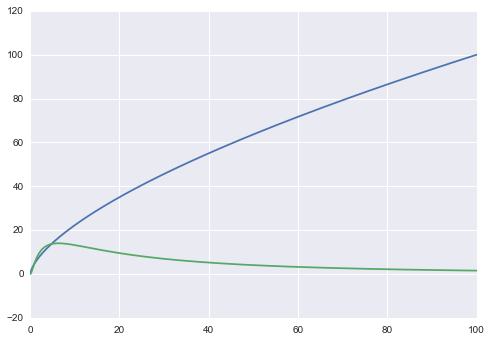

In [121]:
# quickly plot the initial conditions
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [124]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='lm')

In [125]:
solver.result.success

True

## Plot some results

In [126]:
viz = pycollocation.Visualizer(solver)

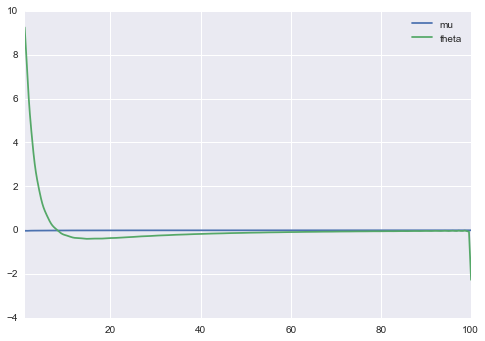

In [127]:
viz.interpolation_knots = np.logspace(0, 2, 1000)
viz.residuals.plot()
plt.show()

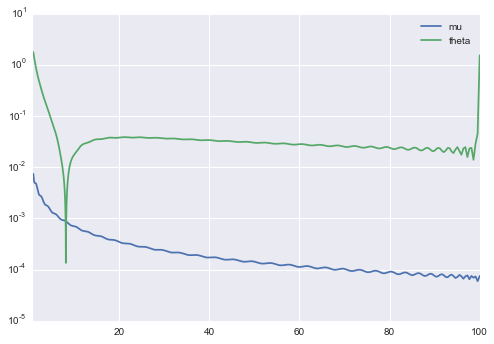

In [128]:
viz.normalized_residuals.plot(logy=True)
plt.show()

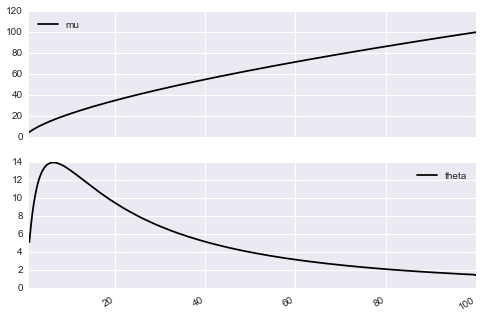

In [129]:
viz.solution.plot(subplots=True)
plt.show()

## Plot the density for firm size

Here I make use of Philipp's trick...

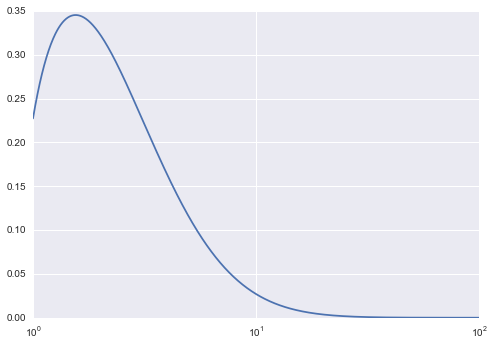

In [34]:
(viz.solution.theta * workers.evaluate_pdf(viz.solution.index.values)).plot(logx=True)
plt.show()

In [35]:
viz2 = pyam.Visualizer(solver)

In [36]:
viz2.interpolation_knots = np.logspace(0, 2, 1000)

In [37]:
viz2.solution.head()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,mu,theta
1.000000,0.594682,0.840785,0.420393,0.297341,0.148671,0.210196,0.074335,0.223006,0.446012,0.630589,0.223006,1.000000,0.353647
1.004620,0.606227,0.842698,0.421349,0.303113,0.151789,0.210997,0.075894,0.224325,0.447964,0.622701,0.223982,1.012887,0.359694
1.009262,0.617780,0.844637,0.422318,0.308890,0.154893,0.211772,0.077447,0.225590,0.449874,0.615074,0.224937,1.025736,0.365707
1.013925,0.629343,0.846599,0.423300,0.314671,0.157984,0.212522,0.078992,0.226803,0.451746,0.607693,0.225873,1.038547,0.371689
1.018610,0.640915,0.848584,0.424292,0.320458,0.161060,0.213246,0.080530,0.227966,0.453580,0.600548,0.226790,1.051322,0.377638


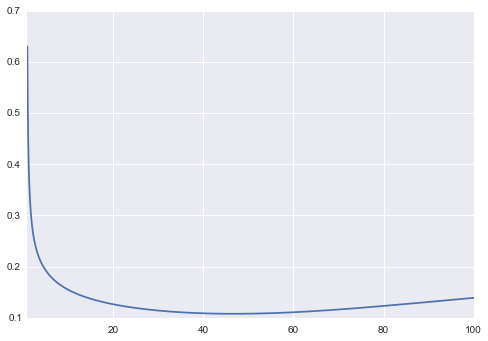

In [39]:
viz2.solution.Fyl.plot()

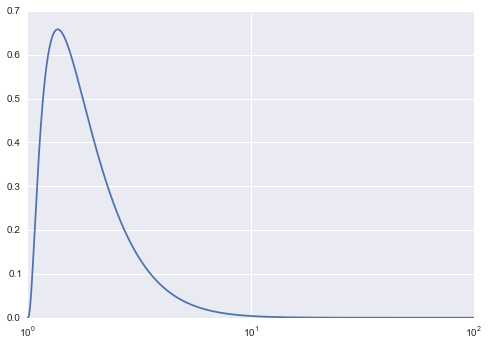

In [53]:
plt.plot(viz.solution.index.values, workers.evaluate_pdf(viz.solution.index.values, norm=False))
plt.xscale('log')
plt.show()